In [61]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from IPython.display import display 
from sklearn.metrics import fbeta_score
import model_utils as model_utils
from sklearn.externals import joblib
import json
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option('display.max_colwidth', -1)


with open('best_config.json') as json_data_file:
    config = json.load(json_data_file)[0]
print(config)
seed = int(config['seed'])
test_size = config['test_size']

dataset = pd.read_csv("datasets/experiments/cie10.csv")
display(dataset.head(n = 5))

labels = dataset[['RIESGO_VIDA']]
features = dataset.drop(['RIESGO_VIDA'], axis = 1)


{'seed': 134.0, 'test_size': 0.1, 'impute': 0.0}


,AFEC_DPTO,AFEC_EDUC,AFEC_GENERO,AFEC_GETNICO,AFEC_MPIO,AFEC_PARENTESCO,AFEC_POBESPECIAL,AFEC_REGAFILIACION,AFEC_TIPOPER,ALTO_COSTO,...,PQR_TIPOPETICION,TRIM,CAPITULO,COD_CIE_10_03,COD_CIE_10_04,CIE10_SEXO,AFEC_EDADR_INF,AFEC_EDADR_SUP,CIE10_RANGO_EDAD,RIESGO_VIDA
0,0.425153,0.400555,0.458335,0.42859,0.454756,0.537595,0.532278,0.419117,0.431765,0.426038,...,0.455397,0.405202,0.420753,0.659895,0.795501,0.407151,0.436994,0.436994,0.413772,1
1,0.552813,0.436647,0.458335,0.42859,0.557585,0.537595,0.419145,0.419117,0.431765,0.426038,...,0.455397,0.405202,0.370675,0.203957,0.111111,0.407151,0.436994,0.436994,0.413772,0
2,0.491303,0.435185,0.458335,0.42859,0.485267,0.537595,0.419145,0.380646,0.431765,0.426038,...,0.455397,0.405202,0.453680,0.457447,0.466667,0.407151,0.436994,0.436994,0.413772,0
3,0.552813,0.400555,0.412468,0.42859,0.527363,0.426399,0.532278,0.419117,0.431765,0.426038,...,0.455397,0.405202,0.248912,0.529412,0.727259,0.407151,0.435873,0.435873,0.413772,1
4,0.411579,0.400555,0.458335,0.42859,0.401531,0.383166,0.419145,0.419117,0.431765,0.426038,...,0.455397,0.405202,0.311155,0.134942,0.130781,0.407151,0.435873,0.435873,0.413772,0


In [8]:
 pd.read_csv("datasets/experiments/cie10.csv").head()

,AFEC_DPTO,AFEC_EDUC,AFEC_GENERO,AFEC_GETNICO,AFEC_MPIO,AFEC_PARENTESCO,AFEC_POBESPECIAL,AFEC_REGAFILIACION,AFEC_TIPOPER,ALTO_COSTO,...,PQR_TIPOPETICION,TRIM,CAPITULO,COD_CIE_10_03,COD_CIE_10_04,CIE10_SEXO,AFEC_EDADR_INF,AFEC_EDADR_SUP,CIE10_RANGO_EDAD,RIESGO_VIDA
0,0.425153,0.400555,0.458335,0.42859,0.454756,0.537595,0.532278,0.419117,0.431765,0.426038,...,0.455397,0.405202,0.420753,0.659895,0.795501,0.407151,0.436994,0.436994,0.413772,1
1,0.552813,0.436647,0.458335,0.42859,0.557585,0.537595,0.419145,0.419117,0.431765,0.426038,...,0.455397,0.405202,0.370675,0.203957,0.111111,0.407151,0.436994,0.436994,0.413772,0
2,0.491303,0.435185,0.458335,0.42859,0.485267,0.537595,0.419145,0.380646,0.431765,0.426038,...,0.455397,0.405202,0.453680,0.457447,0.466667,0.407151,0.436994,0.436994,0.413772,0
3,0.552813,0.400555,0.412468,0.42859,0.527363,0.426399,0.532278,0.419117,0.431765,0.426038,...,0.455397,0.405202,0.248912,0.529412,0.727259,0.407151,0.435873,0.435873,0.413772,1
4,0.411579,0.400555,0.458335,0.42859,0.401531,0.383166,0.419145,0.419117,0.431765,0.426038,...,0.455397,0.405202,0.311155,0.134942,0.130781,0.407151,0.435873,0.435873,0.413772,0


# Experiment results

In [9]:
import pandas as pd
import experiment_datasets as datax
from IPython.display import display, Markdown, Latex

dataset = pd.read_csv(f'datasets/experiments/cie10_results.csv')
display(dataset)

,learner,train_time,pred_time,f_test,f_train
0,SGDClassifier,0.219661,0.007472,0.833008,0.830589
1,MLPClassifier,275.244034,1.771611,0.831914,0.835376
2,PassiveAggressiveClassifier,0.225209,0.007232,0.823599,0.819058
3,XGBClassifier,22.300595,0.524287,0.815864,0.814867
4,GradientBoostingClassifier,22.718659,0.320232,0.809177,0.809231
5,RandomForestClassifier,2.571832,0.437573,0.790145,0.983948
6,BaggingClassifier,13.959082,0.620450,0.783342,0.982915
7,AdaBoostClassifier,5.844942,0.555662,0.782806,0.780315
8,LogisticRegression,2.526419,0.007063,0.781326,0.778550
9,ExtraTreesClassifier,2.488391,0.557214,0.780588,0.998980


In [85]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'labels' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = test_size, random_state = seed, stratify=labels)

# Show the results of the split
print("features_final set has {} samples.".format(features.shape[0]))
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))


features_final set has 175360 samples.
Training set has 157824 samples.
Testing set has 17536 samples.


# Tuning Models

## Tuning SGDClassifier

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=134, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
Unoptimized model
------
F-score: 0.8330

Optimized Model
------
F-score: 0.8515
SGDClassifier(alpha=1e-05, average=False, class_weight='balanced',
       early_stopping=True, epsilon=0.1, eta0=0.01, fit_intercept=True,
       l1_ratio=0.15, learning_rate='constant', loss='hinge',
       max_iter=None, n_iter=None, n_iter_no_change=5, n_jobs=None,
       penalty='none', power_t=0.5, random_state=134, shuffle=True,
       tol=None, validation_fraction=0.1, verbose=0, warm_start=False)


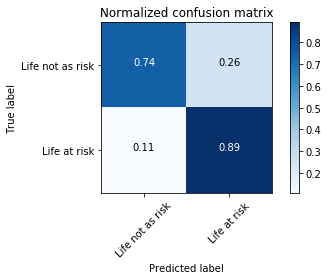

In [42]:
from sklearn.metrics import make_scorer
from sklearn.linear_model import SGDClassifier 

sdg_classifier = SGDClassifier(random_state = seed)
print(sdg_classifier)

sdg_parameters = {
    'alpha':[0.00001],
    'penalty':['none', 'l1', 'l2', 'elasticnet'],
    'eta0':[0.01],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'early_stopping': [True, False],
    'class_weight':['balanced'],
    'fit_intercept': [True, False],
}

sdg_classifier, default_sdg_score, tunned_sdg_score, sdg_matrix = model_utils.tune_classifier(sdg_classifier, sdg_parameters, X_train, X_test, y_train, y_test)

model_utils.plot_confusion_matrix(sdg_matrix, classes=['Life not as risk', 'Life at risk'], normalize = True)
print("Unoptimized model\n------")
print("F-score: {:.4f}".format(default_sdg_score))
print("\nOptimized Model\n------")
print("F-score: {:.4f}".format(tunned_sdg_score))
joblib.dump(sdg_classifier, 'sdg_classifier.joblib')
print(sdg_classifier)

## Tuning PassiveAggressiveClassifier

PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              early_stopping=False, fit_intercept=True, loss='hinge',
              max_iter=None, n_iter=None, n_iter_no_change=5, n_jobs=None,
              random_state=134, shuffle=True, tol=None,
              validation_fraction=0.1, verbose=0, warm_start=False)
Unoptimized model
------
F-score: 0.8236

Optimized Model
------
Final F-score: 0.8271
PassiveAggressiveClassifier(C=1.0, average=False, class_weight='balanced',
              early_stopping=False, fit_intercept=True, loss='hinge',
              max_iter=None, n_iter=None, n_iter_no_change=5, n_jobs=None,
              random_state=134, shuffle=True, tol=None,
              validation_fraction=0.1, verbose=0, warm_start=False)


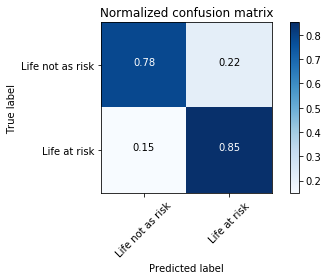

In [50]:
from sklearn.linear_model import PassiveAggressiveClassifier
pa_classifier = PassiveAggressiveClassifier(random_state = seed)

pa_parameters = {
  'class_weight' :['balanced']
}
print(pa_classifier)
pa_classifier, default_pa_score, tuned_pa_score, cnf_pa_matrix = model_utils.tune_classifier(pa_classifier, pa_parameters, X_train, X_test, y_train, y_test)

model_utils.plot_confusion_matrix(cnf_pa_matrix, classes=['Life not as risk', 'Life at risk'], normalize = True)
print("Unoptimized model\n------")
print("F-score: {:.4f}".format(default_pa_score))
print("\nOptimized Model\n------")
print("Final F-score: {:.4f}".format(tuned_pa_score))

joblib.dump(pa_classifier, 'pa_classifier.joblib') 
print(pa_classifier)


# Stacking
## Stacking with to best classifiers

F-score on validation data: 0.7868


StackingClassifier(average_probas=False,
          classifiers=[SGDClassifier(alpha=1e-05, average=False, class_weight='balanced',
       early_stopping=True, epsilon=0.1, eta0=0.01, fit_intercept=True,
       l1_ratio=0.15, learning_rate='constant', loss='hinge',
       max_iter=None, n_iter=None, n_iter_no_change=5, n_jobs=None,
       penalty='no...te=134, shuffle=True, tol=None,
              validation_fraction=0.1, verbose=0, warm_start=False)],
          meta_classifier=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=134, verbose=0, warm_start=False),
          store_train_meta_features=False, use_clones=True,
          use_features_in_secondary=True, 

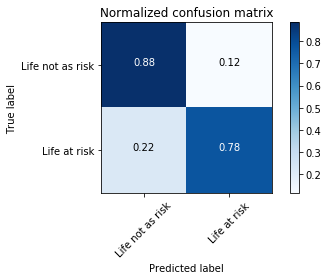

In [51]:
sclf_two, sclf_score = model_utils.get_stack_two(sdg_classifier, pa_classifier, X_train, X_test, y_train, y_test, seed)

joblib.dump(sclf_two, 'sclf_two.joblib') 

model_utils.model_validation('sclf_two.joblib', X_test, y_test)

## Tuning MLPClassifier

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=134, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
Unoptimized model
------
Time: 3210.6174252033234
------
F-score: 0.8319

Optimized Model
------
Final F-score: 0.8097
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=100, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.8,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=134, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=Fa

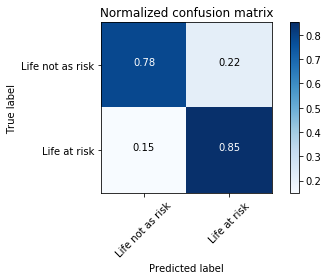

In [94]:
from sklearn.neural_network import MLPClassifier
from time import time

ml_classifier = MLPClassifier(random_state = seed)

ml_parameters = {
    'hidden_layer_sizes': [50, 100, 150, 200, 250],
    'solver':['lbfgs', 'sgd', 'adam'],
    'early_stopping':[True],
    'momentum':[0.8, 0.9, 0.95],
    'learning_rate_init': [0.001, 0.00001]
}
print(ml_classifier)
start = time()

ml_classifier, default_ml_score, tuned_ml_score, cnf_ml_matrix = model_utils.tune_classifier(ml_classifier, ml_parameters, X_train, X_test, y_train, y_test)

model_utils.plot_confusion_matrix(cnf_pa_matrix, classes=['Life not as risk', 'Life at risk'], normalize = True)
end = time()
pred_time = end - start
print("Unoptimized model\n------")
print(f"Time: {pred_time}\n------")
print("F-score: {:.4f}".format(default_ml_score))
print("\nOptimized Model\n------")
print("Final F-score: {:.4f}".format(tuned_ml_score))

joblib.dump(ml_classifier, 'ml_classifier.joblib') 
print(ml_classifier)
